In [1]:
include("package.jl")
include("kagome_setup.jl")
include("KH_hamiltonian.jl")
include("Full_Orthogonalization_Lanczos.jl")

itFOLM_new (generic function with 3 methods)

This is the Finite-temperature ED code for Kitaev-Heisernberg model on $2 \times 2 \times 3$ Kagome lattice, in which the periodic boundary condition is used. If we replace the summation of $N_s$ by $R$ times random sampling and the original Hilbert space by $M$-dimentional Krylov space, the partition function can be written as:

\begin{equation}
    Z(T) = \frac{N_s}{R} \sum_{r=1}^{R} \sum_{j=1}^{M-1} e^{-\beta E_j^r} | \langle V_r | \psi_j^r \rangle |^2
\end{equation}
where $| V_r \rangle $ is a normalized random initial vector.

The basic claim of Finite-temperature Lanczos Method(FTLM) is that very accurate results can be obtained for severly reduced number of Lanczos step $M \ll N_s$ and random sampling $R \ll N_s$. 

In [2]:
function FTLM(A::AbstractMatrix, M::Integer, R::Integer, Op = nothing)
    """Partition Function by the Finite Temperature Lanczos Method
       Input: A := Hamiltonian Matrix
              M := The number of Lanczos step
              R := The number of random sampling
              temp := Temperature
              Op := A general operator
        Output: V := [E(rj),  <v psi>*<psi v>, <v psi>*<psi O v>]
                dim/R
    """
    dim = size(A)[1]; 
    if Op == nothing
        n = 2
    else
        n = 3
    end
    
    V = zeros(R, M, n)
    for r = 1:R
        T, Q = itFOLM_new(A, M, true)
        vals, vecs = eigen(T) 
        emin = minimum(vals)
        for j = 1:M
            V[r,j,1] = vals[j] - emin
            V[r,j,2] = vecs[1,j] * vecs[1,j]'
            if Op != nothing
                V[r,j,3] = vecs[1,j] * (vecs[:,j]' * Q' * Op * v0)
            end
        end
    end
    return V, dim/R      
end

function FTLM_partition(V::AbstractArray, fac::Number, t::Number)
    Z = 0.
    R, M, n = size(V);
    for r = 1:R, j = 1:M
        Z += exp(-V[r,j,1]/t)* V[r,j,2]
    end
    return Z * fac
end

function FTLM_EandC(V::AbstractArray, fac::Number, t::Number, return_c = true)
    E = 0. ;  
    R, M, n = size(V); Z = FTLM_partition(V, fac, t);
    for r = 1:R, j = 1:M
        E += V[r,j,1] * exp(-V[r,j,1]/t)* V[r,j,2]
    end
    E = E * fac / Z
    
    if return_c
        C = 0.
        for r = 1:R, j = 1:M
            C += V[r,j,1] * V[r,j,1] * exp(-V[r,j,1]/t) * V[r,j,2]
        end
        C = C * fac /(Z * t * t)
        C -= E*E /(t * t)
        return E, C
    else
        return E
    end

end

FTLM_EandC (generic function with 2 methods)

In [3]:
"""Test code"""
θ = 0.2
J = cospi(θ) * ones(3)
K = sinpi(θ) * ones(3)

la = Lattice(2,2)
N = sitenum(la)
dim = dimension(la)

Hk = Kitaev(K, la)
Hh = Heisenberg(J, la)
Htot = Hk + Hh;

V, fac = FTLM(Htot, 90, 50);
println("Finish!")

Finish!


In [4]:
""" Thermaldynamic quanties"""
step = 100
temp = [10^x for x in LinRange(-4,2,step)]
Zt = zeros(step)
Et = zeros(step)
Ct = zeros(step)
St = zeros(step)

for i = 1: step
    t = temp[i]
    Zt[i] = FTLM_partition(V, fac, t)
    Et[i], Ct[i] = FTLM_EandC(V, fac, t)
    St[i] = Et[i]/t + log(Zt[i])
end

println("Finish calculate Thermaldynamic quanties!")

Finish calculate Thermaldynamic quanties!


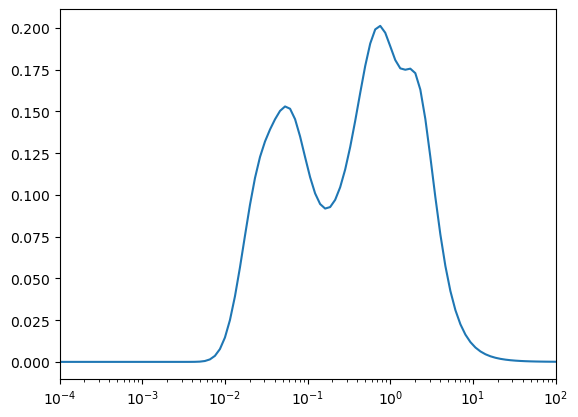

(0.00010000000000000005, 100)

In [7]:
#println(length(C))
#println(C)
semilogx(temp, Ct/N)
xlim(10^-4, 10^2)